In [ ]:
# Importing Libraries
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy import stats

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Model selection and validation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score

# Linear models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# Tree-based models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, ExtraTreesRegressor, 
                              AdaBoostRegressor, GradientBoostingRegressor, 
                              HistGradientBoostingRegressor)

# Other models
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from xgboost import XGBRegressor

# Model composition
from sklearn.compose import TransformedTargetRegressor

# Metrics
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error, 
                             make_scorer)


In [8]:
df=pd.read_csv("Final_ETA.csv")
df.head()

,Unnamed: 0,Latitude,Longitude,Speed,Accuracy,day_of_week,day_of_year,hour_sin,hour_cos,minute_sin,minute_cos,cumulative_time_minutes,is_stationary,stationary_duration,speed_rolling_mean_5,speed_rolling_std_5,acceleration,distance_to_next
0,4,23.154411,72.668269,0.000000,10.0,2,87,-0.258819,-0.965926,0.104528,0.994522,1.716667,1,3.0,0.075252,0.121621,-0.279494,0.002266
1,5,23.154430,72.668261,0.000000,10.0,2,87,-0.258819,-0.965926,0.104528,0.994522,1.750000,1,5.0,0.075252,0.121621,0.000000,0.002131
2,6,23.154436,72.668241,1.302247,10.0,2,87,-0.258819,-0.965926,0.104528,0.994522,1.783333,0,2.0,0.335702,0.552234,1.302247,0.002826
3,7,23.154448,72.668217,1.910134,10.0,2,87,-0.258819,-0.965926,0.104528,0.994522,1.816667,0,2.0,0.698375,0.863704,0.607887,0.003535
4,8,23.154467,72.668189,0.000000,10.0,2,87,-0.258819,-0.965926,0.104528,0.994522,1.850000,1,4.0,0.642476,0.905619,-1.910134,0.003730


In [9]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [10]:
df.columns

Index(['Latitude', 'Longitude', 'Speed', 'Accuracy', 'day_of_week',
       'day_of_year', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos',
       'cumulative_time_minutes', 'is_stationary', 'stationary_duration',
       'speed_rolling_mean_5', 'speed_rolling_std_5', 'acceleration',
       'distance_to_next'],
      dtype='object')

In [11]:


# Define feature groups based on data characteristics
robust_features = ['Latitude', 'Longitude', 'Speed', 'Accuracy', 'acceleration', 'distance_to_next']
standard_features = ['speed_rolling_mean_5', 'speed_rolling_std_5', 'stationary_duration']
minmax_features = ['day_of_week', 'day_of_year', 'cumulative_time_minutes']
# No scaling needed: ['hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'is_stationary']

# Initialize scalers
robust_scaler = RobustScaler()
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# Apply scaling transformations
print("Applying RobustScaler to GPS and movement data...")
df[robust_features] = robust_scaler.fit_transform(df[robust_features])

print("Applying StandardScaler to rolling statistics...")
df[standard_features] = standard_scaler.fit_transform(df[standard_features])

print("Applying MinMaxScaler to temporal features...")
df[minmax_features] = minmax_scaler.fit_transform(df[minmax_features])

print("Scaling complete! Data is now ready for model training.")

# Verify scaling results
print("\nFeature ranges after scaling:")
print(df[robust_features + standard_features + minmax_features].describe())


Applying RobustScaler to GPS and movement data...
Applying StandardScaler to rolling statistics...
Applying MinMaxScaler to temporal features...
Scaling complete! Data is now ready for model training.

Feature ranges after scaling:
          Latitude    Longitude        Speed     Accuracy  acceleration  \
count  8525.000000  8525.000000  8525.000000  8525.000000   8525.000000   
mean      0.127400     0.373432    -0.046571     1.366139      0.000339   
std       0.515989     0.831831     0.503329     9.393972      1.765118   
min      -0.557775    -0.486682    -0.703412     0.000000    -52.808018   
25%      -0.341267    -0.188771    -0.600466     0.000000     -0.400921   
50%       0.000000     0.000000     0.000000     0.000000      0.000000   
75%       0.658733     0.811229     0.399534     0.000000      0.599079   
max       0.981872     2.458853     1.309049    86.000000     17.658997   

       distance_to_next  speed_rolling_mean_5  speed_rolling_std_5  \
count       8525.00000

In [12]:
df.to_csv("Inspecting.csv")

In [13]:
final_features = [
    'Latitude', 'Longitude', 'Speed', 'acceleration', 
    'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos',
    'day_of_week', 'is_stationary', 'distance_to_next'
]

# Select final features
df_final = df[final_features].copy()
print(f"Training with {len(final_features)} features: {final_features}")


Training with 11 features: ['Latitude', 'Longitude', 'Speed', 'acceleration', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'day_of_week', 'is_stationary', 'distance_to_next']


In [14]:
# Input - Output Feature Split 
y=df['cumulative_time_minutes']
x=df_final

In [15]:
x.head()

,Latitude,Longitude,Speed,acceleration,hour_sin,hour_cos,minute_sin,minute_cos,day_of_week,is_stationary,distance_to_next
0,0.625517,2.458853,-0.703412,-0.834102,-0.258819,-0.965926,0.104528,0.994522,0.0,1,-0.509259
1,0.625693,2.458707,-0.703412,0.000000,-0.258819,-0.965926,0.104528,0.994522,0.0,1,-0.520161
2,0.625743,2.458355,-0.586837,3.886331,-0.258819,-0.965926,0.104528,0.994522,0.0,0,-0.464223
3,0.625861,2.457932,-0.532420,1.814133,-0.258819,-0.965926,0.104528,0.994522,0.0,0,-0.407091
4,0.626037,2.457443,-0.703412,-5.700464,-0.258819,-0.965926,0.104528,0.994522,0.0,1,-0.391391


In [16]:
y.head()

0    0.000000
1    0.000003
2    0.000006
3    0.000009
4    0.000012
Name: cumulative_time_minutes, dtype: float64

In [17]:
# Train Test Split 
# Splitting the dataset into Training and Testing
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [18]:
x_train.columns

Index(['Latitude', 'Longitude', 'Speed', 'acceleration', 'hour_sin',
       'hour_cos', 'minute_sin', 'minute_cos', 'day_of_week', 'is_stationary',
       'distance_to_next'],
      dtype='object')

In [19]:
y_train

549     0.001366
6940    0.932921
764     0.001868
6869    0.932812
2716    0.006848
          ...   
5734    0.930964
5191    0.930132
5390    0.930437
860     0.002147
7270    0.933428
Name: cumulative_time_minutes, Length: 6820, dtype: float64

In [20]:
y_test

7505    0.998415
2957    0.926698
7033    0.933065
1084    0.002762
856     0.002135
          ...   
7207    0.933331
3257    0.927157
6348    0.931994
8472    0.999920
7792    0.998879
Name: cumulative_time_minutes, Length: 1705, dtype: float64

### Model Training


In [21]:


# Define your model ensemble
models = {
    'Extra Trees': TransformedTargetRegressor(
        ExtraTreesRegressor(n_estimators=200, random_state=42),
        transformer=StandardScaler()
    ),
    'Random Forest': TransformedTargetRegressor(
        RandomForestRegressor(n_estimators=150, random_state=42),
        transformer=StandardScaler()
    ),
    'XGBoost': TransformedTargetRegressor(
        xgb.XGBRegressor(n_estimators=100, random_state=42),
        transformer=StandardScaler()
    )
}

# Train and evaluate
results = {}
for name, model in models.items():
    # Fit model
    model.fit(x_train, y_train)
    
    # Predictions
    y_pred = model.predict(x_test)
    
    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    print(f"{name}: R² = {r2:.4f}, MSE = {mse:.2e}, MAE = {mae:.2e}")


Extra Trees: R² = 0.9020, MSE = 1.91e-02, MAE = 5.77e-02
Random Forest: R² = 0.8280, MSE = 3.35e-02, MAE = 7.94e-02
XGBoost: R² = 0.8643, MSE = 2.64e-02, MAE = 8.20e-02


In [22]:
# Define hyperparameter grids
param_grids = {
    'Extra Trees': {
        'regressor__n_estimators': [100, 200, 300, 400],
        'regressor__max_features': ['auto', 'sqrt', 'log2', 0.3, 0.5],
        'regressor__max_depth': [None, 10, 20, 30, 40],
        'regressor__min_samples_split': [2, 5, 10, 15],
        'regressor__min_samples_leaf': [1, 2, 4, 6],
        'regressor__bootstrap': [True, False]
    },
    
    'Random Forest': {
        'regressor__n_estimators': [100, 150, 200, 300],
        'regressor__max_features': ['auto', 'sqrt', 'log2', 0.3, 0.5],
        'regressor__max_depth': [None, 10, 20, 30, 40],
        'regressor__min_samples_split': [2, 5, 10, 15],
        'regressor__min_samples_leaf': [1, 2, 4, 6],
        'regressor__bootstrap': [True, False]
    },
    
    'XGBoost': {
        'regressor__n_estimators': [100, 200, 300, 400],
        'regressor__max_depth': [3, 4, 5, 6, 7],
        'regressor__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
        'regressor__subsample': [0.7, 0.8, 0.9, 1.0],
        'regressor__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
        'regressor__reg_alpha': [0, 0.1, 0.5, 1.0],
        'regressor__reg_lambda': [0, 0.1, 0.5, 1.0]
    }
}

In [23]:
# Create base models
base_models = {
    'Extra Trees': TransformedTargetRegressor(
        ExtraTreesRegressor(random_state=42, n_jobs=-1),
        transformer=StandardScaler()
    ),
    'Random Forest': TransformedTargetRegressor(
        RandomForestRegressor(random_state=42, n_jobs=-1),
        transformer=StandardScaler()
    ),
    'XGBoost': TransformedTargetRegressor(
        xgb.XGBRegressor(random_state=42, n_jobs=-1),
        transformer=StandardScaler()
    )
}

# Perform hyperparameter tuning
best_models = {}
tuning_results = {}

for name, model in base_models.items():
    print(f"\n{'='*50}")
    print(f"Tuning {name}...")
    print(f"{'='*50}")
    
    # Use RandomizedSearchCV for faster results (or GridSearchCV for exhaustive search)
    search = RandomizedSearchCV(
        model,
        param_grids[name],
        n_iter=50,  # Reduce for faster execution
        scoring='neg_mean_squared_error',
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    
    # Fit the search
    search.fit(x_train, y_train)
    
    # Store results
    best_models[name] = search.best_estimator_
    tuning_results[name] = {
        'best_params': search.best_params_,
        'best_score': -search.best_score_,  # Convert back from negative
        'cv_results': search.cv_results_
    }
    
    print(f"Best parameters for {name}: {search.best_params_}")
    print(f"Best CV MSE: {-search.best_score_:.4f}")


Tuning Extra Trees...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\aryan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
19 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\aryan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\aryan\anaconda3\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\aryan\anaconda3\Lib\site-packages\sklearn\compose\_target.py", line 293, in fit
    self.regressor_.f

Best parameters for Extra Trees: {'regressor__n_estimators': 100, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 0.3, 'regressor__max_depth': None, 'regressor__bootstrap': True}
Best CV MSE: 0.0162

Tuning Random Forest...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\aryan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\aryan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\aryan\anaconda3\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\aryan\anaconda3\Lib\site-packages\sklearn\compose\_target.py", line 293, in fit
    self.regressor_.f

Best parameters for Random Forest: {'regressor__n_estimators': 300, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 2, 'regressor__max_features': 0.3, 'regressor__max_depth': None, 'regressor__bootstrap': False}
Best CV MSE: 0.0229

Tuning XGBoost...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for XGBoost: {'regressor__subsample': 0.9, 'regressor__reg_lambda': 1.0, 'regressor__reg_alpha': 1.0, 'regressor__n_estimators': 400, 'regressor__max_depth': 6, 'regressor__learning_rate': 0.2, 'regressor__colsample_bytree': 0.9}
Best CV MSE: 0.0206


In [24]:
# Evaluate all tuned models
results_tuned = {}

for name, model in best_models.items():
    # Predictions
    y_pred = model.predict(x_test)
    
    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results_tuned[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    print(f"{name} (Tuned): R² = {r2:.4f}, MSE = {mse:.2e}, MAE = {mae:.2e}")

# Compare with original results
print("\n" + "="*60)
print("PERFORMANCE COMPARISON")
print("="*60)
print(f"{'Model':<15} {'Original R²':<12} {'Tuned R²':<10} {'Improvement':<12}")
print("-" * 60)

for name in results_tuned.keys():
    if name in results:  # Assuming you have original results
        orig_r2 = results[name]['R2']
        tuned_r2 = results_tuned[name]['R2']
        improvement = tuned_r2 - orig_r2
        print(f"{name:<15} {orig_r2:<12.4f} {tuned_r2:<10.4f} {improvement:<12.4f}")


Extra Trees (Tuned): R² = 0.9204, MSE = 1.55e-02, MAE = 5.84e-02
Random Forest (Tuned): R² = 0.8831, MSE = 2.28e-02, MAE = 6.52e-02
XGBoost (Tuned): R² = 0.9006, MSE = 1.94e-02, MAE = 7.06e-02

PERFORMANCE COMPARISON
Model           Original R²  Tuned R²   Improvement 
------------------------------------------------------------
Extra Trees     0.9020       0.9204     0.0184      
Random Forest   0.8280       0.8831     0.0550      
XGBoost         0.8643       0.9006     0.0364      


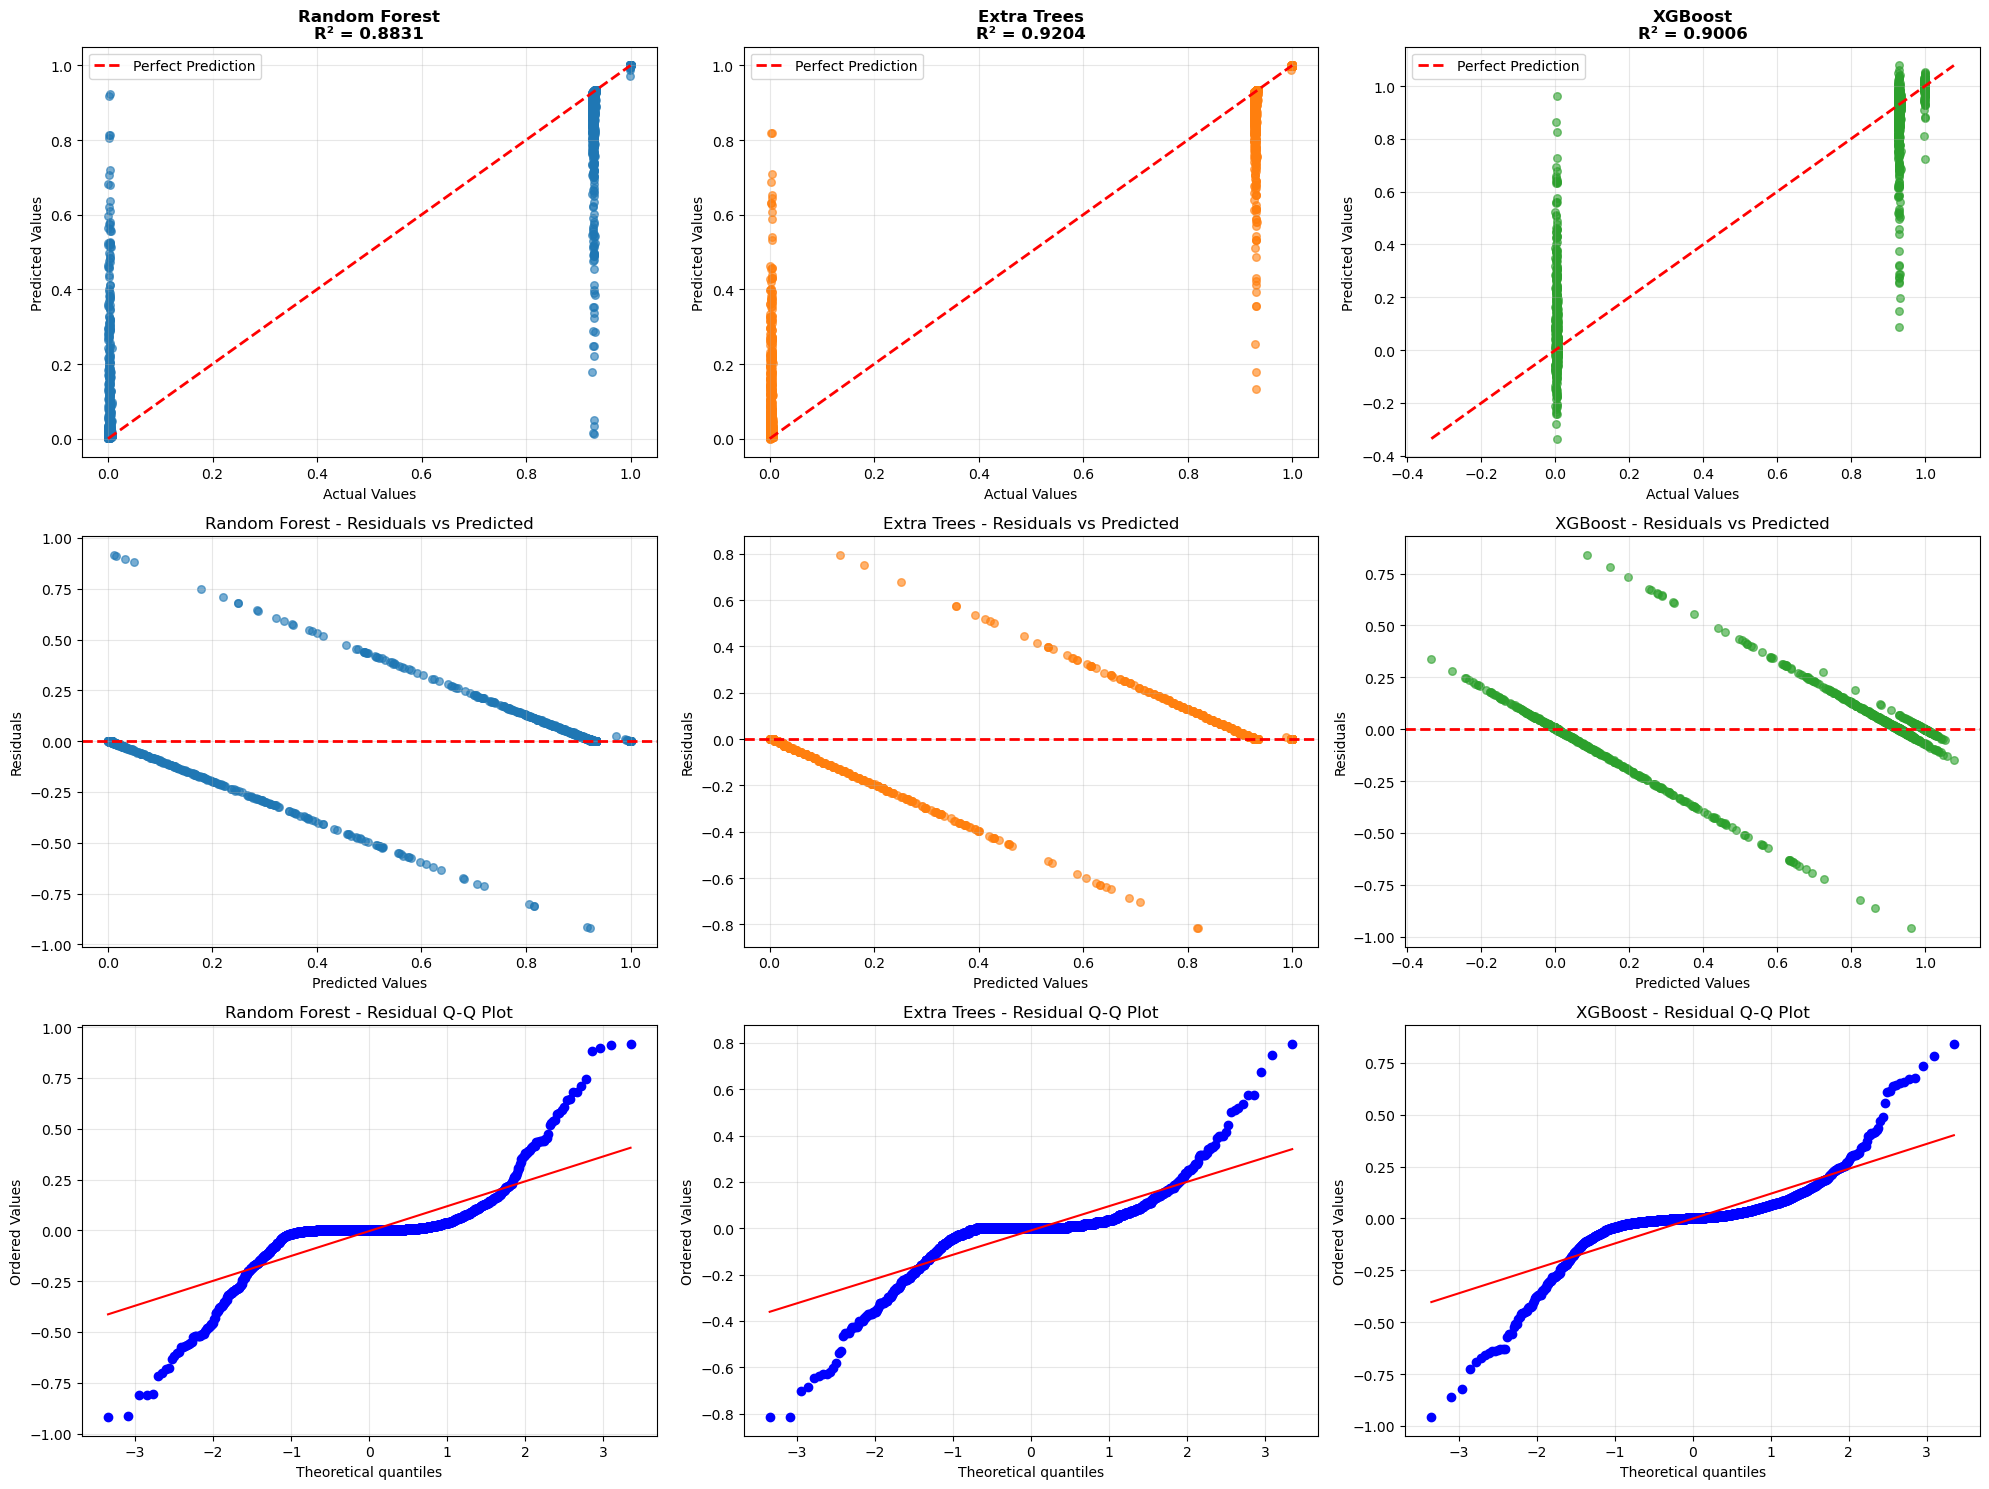

<Figure size 1200x800 with 0 Axes>

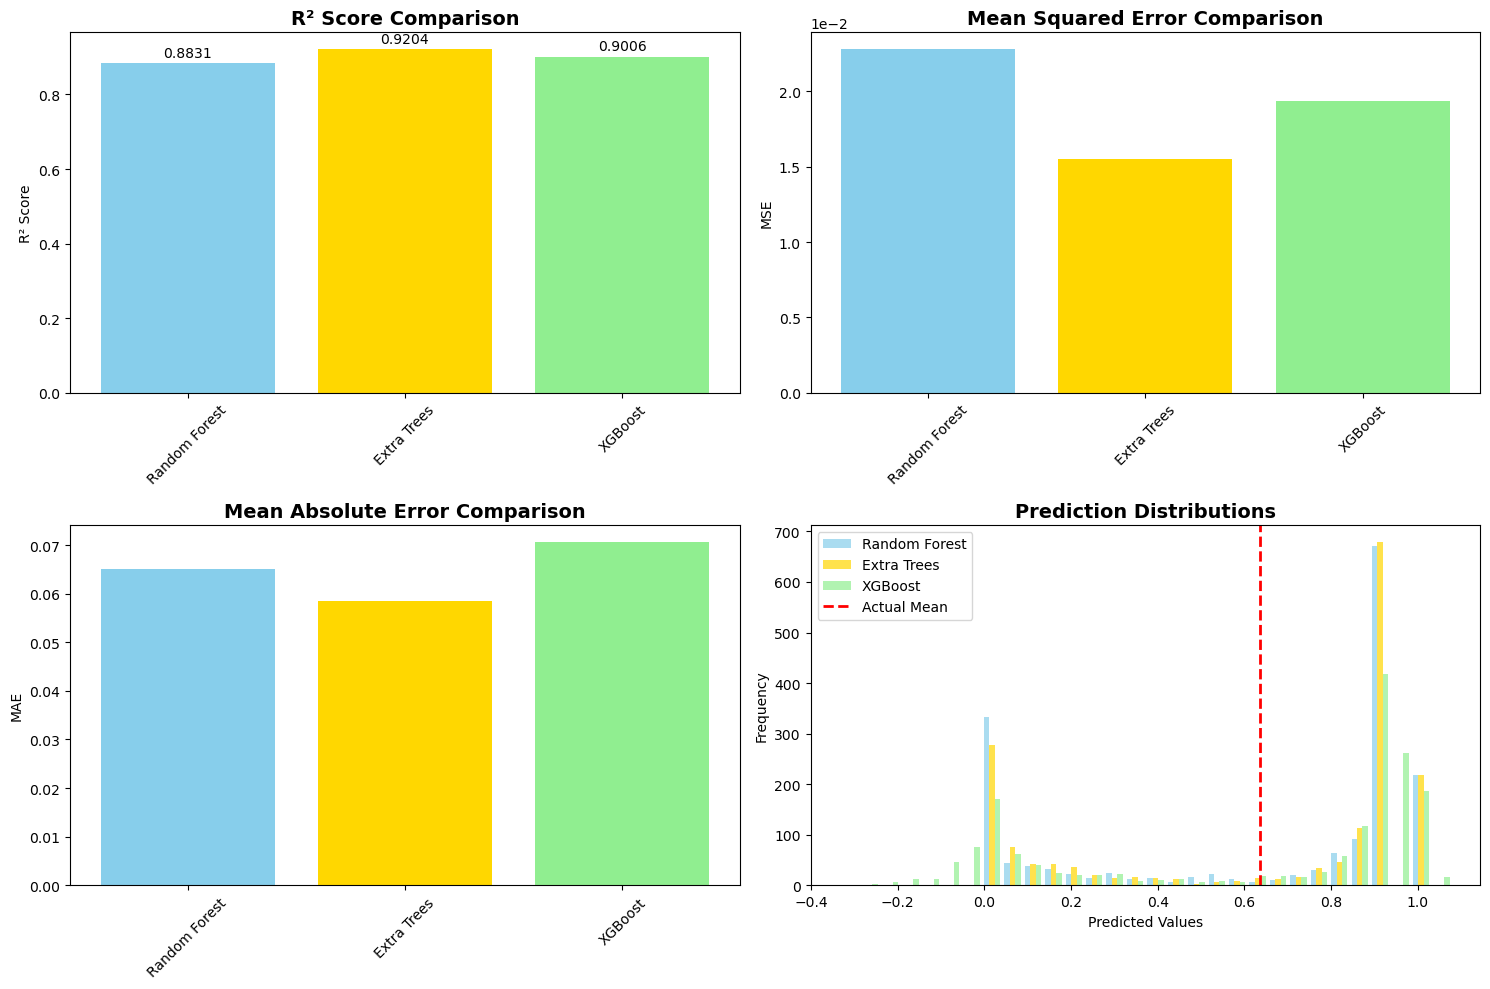

In [28]:
# Set up the plotting style
plt.style.use('default')
fig = plt.figure(figsize=(20, 15))

# Reorder models to put Extra Trees in the middle
model_names_ordered = list(best_models.keys())
if 'Extra Trees' in model_names_ordered:
    # Remove Extra Trees from current position
    model_names_ordered.remove('Extra Trees')
    # Insert Extra Trees in the middle
    middle_index = len(model_names_ordered) // 2
    model_names_ordered.insert(middle_index, 'Extra Trees')

# Create ordered dictionary with Extra Trees in middle
best_models_ordered = {name: best_models[name] for name in model_names_ordered}

# Create a comprehensive evaluation dashboard
n_models = len(best_models_ordered)
rows = 3
cols = n_models

# Color palette for different models
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

model_predictions = {}

# Generate predictions for all models (with Extra Trees in middle)
for i, (name, model) in enumerate(best_models_ordered.items()):
    y_pred = model.predict(x_test)
    model_predictions[name] = y_pred
    
    # 1. Actual vs Predicted Plot
    plt.subplot(rows, cols, i + 1)
    plt.scatter(y_test, y_pred, alpha=0.6, color=colors[i % len(colors)], s=30)
    
    # Perfect prediction line (y=x)
    min_val = min(min(y_test), min(y_pred))
    max_val = max(max(y_test), max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    # Calculate and display R²
    r2 = results_tuned[name]['R2']
    plt.title(f'{name}\nR² = {r2:.4f}', fontsize=12, fontweight='bold')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Residual Plot
    plt.subplot(rows, cols, cols + i + 1)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.6, color=colors[i % len(colors)], s=30)
    plt.axhline(y=0, color='r', linestyle='--', lw=2)
    plt.title(f'{name} - Residuals vs Predicted', fontsize=12)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid(True, alpha=0.3)
    
    # 3. Residual Distribution (Q-Q Plot)
    plt.subplot(rows, cols, 2*cols + i + 1)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(f'{name} - Residual Q-Q Plot', fontsize=12)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance Summary Plot
plt.figure(figsize=(12, 8))

# Extract metrics (using reordered model names)
model_names = model_names_ordered
r2_scores = [results_tuned[name]['R2'] for name in model_names]
mse_scores = [results_tuned[name]['MSE'] for name in model_names]
mae_scores = [results_tuned[name]['MAE'] for name in model_names]

# Create subplots for metrics comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Define colors that will put Extra Trees in middle with distinct color
bar_colors = []
for i, name in enumerate(model_names):
    if name == 'Extra Trees':
        bar_colors.append('gold')  # Highlight Extra Trees
    else:
        bar_colors.append(['skyblue', 'lightcoral', 'lightgreen', 'plum'][i % 4])

# R² Score Comparison
bars1 = axes[0, 0].bar(model_names, r2_scores, color=bar_colors)
axes[0, 0].set_title('R² Score Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(r2_scores):
    axes[0, 0].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

# MSE Comparison
bars2 = axes[0, 1].bar(model_names, mse_scores, color=bar_colors)
axes[0, 1].set_title('Mean Squared Error Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('MSE')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# MAE Comparison
bars3 = axes[1, 0].bar(model_names, mae_scores, color=bar_colors)
axes[1, 0].set_title('Mean Absolute Error Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].tick_params(axis='x', rotation=45)

# Prediction Distribution Comparison
hist_colors = []
for name in model_names:
    if name == 'Extra Trees':
        hist_colors.append('gold')
    else:
        hist_colors.append(['skyblue', 'lightcoral', 'lightgreen', 'plum'][model_names.index(name) % 4])

axes[1, 1].hist([model_predictions[name] for name in model_names], 
                bins=30, alpha=0.7, label=model_names, 
                color=hist_colors)
axes[1, 1].axvline(np.mean(y_test), color='red', linestyle='--', linewidth=2, label='Actual Mean')
axes[1, 1].set_title('Prediction Distributions', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Predicted Values')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

plt.tight_layout()
plt.show()
